In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

CL_Bert_Base_Uncased.ipynb
CL_CNN_BiLSTM_Glove100d_TFIDF.ipynb
CL_CNN_Glove100d_TFIDF.ipynb
CL_CNN_Model.ipynb
CL_Glove100d_AVGW2V_POS.ipynb
CL_Glove100d_AVGW2V_TFIDFAVGW2V_POS.ipynb
CL_Glove100d_BOW_TFIDF_AvgW2V.ipynb
CL_Glove100d_BOW_TFIDF_AvgW2V_SVD.ipynb
CL_Glove100d_FastText_AVGW2V_POS.ipynb
CL_Glove300d_BOW_TFIDF_AVGW2V.ipynb
Dataset
FastText
GloveVector


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from mlxtend.regressor import StackingRegressor

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [4]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [5]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

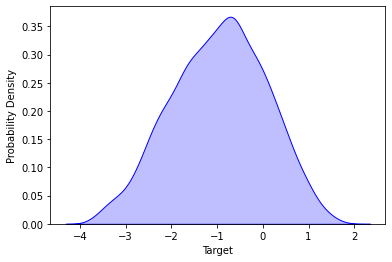

In [7]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [8]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

### Pretrained Glove Vector assignment

In [9]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

# !wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

In [10]:
#unzip the downloaded glove vectors to drive
# !unzip glove*.zip

In [11]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

d_model = 300
glove_dict = {}
f = open('/content/drive/MyDrive/DeepLearning/Common Literacy/GloveVector/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_dict))

# checking the dictionary word shape
print(glove_dict['the'].shape)

Indexing word vectors.
Found 400000 word vectors.
(300,)


In [12]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_dict.keys())

In [13]:
# # code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_50d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

### Pretrained Fast Text Vectors

In [15]:
# https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

# creating the dictionary if word and vectors
print('Indexing word vectors.')

fasttext_dict = {}
f = open('/content/drive/MyDrive/DeepLearning/Common Literacy/FastText/wiki.simple.vec', encoding='utf-8')
for line in f:
  values = line.strip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  fasttext_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(fasttext_dict))

# checking the dictionary word shape
print(fasttext_dict['the'].shape)

Indexing word vectors.
Found 111024 word vectors.
(300,)


In [16]:
# creating a set of the keys from glove dictionary
fasttext_words = set(fasttext_dict.keys())

### Cleaning the text data for any special characters and numerical characters

In [17]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(r'\w*\d\w*', '', phrase).strip()
    return phrase

In [18]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 1744.77it/s]


In [19]:
print(df_train['excerpt'].values[0])
print("="*100)
print(df_train['cleaned_excerpt'].values[0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.
young p

In [20]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [21]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(d_model) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_dict[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Glove and FastText Average Word 2 Vec With Positional Encoding

In [22]:
def positionalEncoding2d(max_sentence_length,d_model):
  positional_embeddings = np.zeros((max_sentence_length, d_model))
  for position in range(max_sentence_length):
      for i in range(0, d_model, 2):
        positional_embeddings[position, i] = (np.sin(position/(10000 ** ((2*i) / d_model))))
        positional_embeddings[position, i + 1] = (np.cos(position/(10000 ** ((2*(i+1)) / d_model))))
  return positional_embeddings

def Avg_W2V_Pos(selfie): # give a pandas series into
  array_col_size = selfie.size
  AvgW2V_list = []; 
  for sentence in tqdm(selfie.values): 
      sentence = sentence.split()
      max_sentence_length = len(sentence)
      empty_vector_glove = np.empty((0,d_model),dtype=float)
      empty_vector_fasttext = np.empty((0,d_model),dtype=float)
      posEmbed = positionalEncoding2d(max_sentence_length,d_model)
      for word in sentence:
          if word in glove_words: 
              vector_glove = glove_dict[word] 
              vectorTranspose_glove = np.reshape(vector_glove,(-1,d_model))
              empty_vector_glove = np.append(empty_vector_glove,vectorTranspose_glove,axis=0)
          else:
            vectorZeros_glove = np.zeros((1,d_model),dtype=float)
            empty_vector_glove = np.append(empty_vector_glove,vectorZeros_glove,axis=0)

          if word in fasttext_words: 
              vector_fasttext = fasttext_dict[word] 
              vectorTranspose_fasttext = np.reshape(vector_fasttext,(-1,d_model))
              empty_vector_fasttext = np.append(empty_vector_fasttext,vectorTranspose_fasttext,axis=0)
          else:
            vectorZeros_fasttext = np.zeros((1,d_model),dtype=float)
            empty_vector_fasttext = np.append(empty_vector_fasttext,vectorZeros_fasttext,axis=0)
      WordEmbed_Glove_Fasttext = np.add(empty_vector_fasttext, empty_vector_glove)
      WordEmbedPOS = np.add(posEmbed, WordEmbed_Glove_Fasttext)
      WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
      WordEmbedPOSColSum /= max_sentence_length
      AvgW2V_list.append(WordEmbedPOSColSum)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Glove and FastText Concatenate Average Word 2 Vec With Positional Encoding

In [23]:
def positionalEncoding2d(max_sentence_length,d_model):
  positional_embeddings = np.zeros((max_sentence_length, d_model))
  for position in range(max_sentence_length):
      for i in range(0, d_model, 2):
        positional_embeddings[position, i] = (np.sin(position/(10000 ** ((2*i) / d_model))))
        positional_embeddings[position, i + 1] = (np.cos(position/(10000 ** ((2*(i+1)) / d_model))))
  return positional_embeddings

def Avg_W2V_Pos_Concat(selfie): # give a pandas series into
  array_col_size = selfie.size
  AvgW2V_list = []; 
  for sentence in tqdm(selfie.values): 
      sentence = sentence.split()
      max_sentence_length = len(sentence)
      empty_vector_glove = np.empty((0,d_model),dtype=float)
      empty_vector_fasttext = np.empty((0,d_model),dtype=float)
      posEmbed = positionalEncoding2d(max_sentence_length,d_model)
      for word in sentence:
          if word in glove_words: 
              vector_glove = glove_dict[word] 
              vectorTranspose_glove = np.reshape(vector_glove,(-1,d_model))
              empty_vector_glove = np.append(empty_vector_glove,vectorTranspose_glove,axis=0)
          else:
            vectorZeros_glove = np.zeros((1,d_model),dtype=float)
            empty_vector_glove = np.append(empty_vector_glove,vectorZeros_glove,axis=0)

          if word in fasttext_words: 
              vector_fasttext = fasttext_dict[word] 
              vectorTranspose_fasttext = np.reshape(vector_fasttext,(-1,d_model))
              empty_vector_fasttext = np.append(empty_vector_fasttext,vectorTranspose_fasttext,axis=0)
          else:
            vectorZeros_fasttext = np.zeros((1,d_model),dtype=float)
            empty_vector_fasttext = np.append(empty_vector_fasttext,vectorZeros_fasttext,axis=0)
      WordEmbed_Glove = np.add(posEmbed, empty_vector_glove)
      WordEmbed_Fasttext = np.add(posEmbed, empty_vector_fasttext)
      WordEmbedPOS = np.hstack((WordEmbed_Glove, WordEmbed_Fasttext))
      WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
      WordEmbedPOSColSum /= max_sentence_length
      AvgW2V_list.append(WordEmbedPOSColSum)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

In [24]:
# test_x = df_train['excerpt']

# print(test_x[0:2])

# X_train_excerpt_test = Avg_W2V_Pos_Concat(test_x[0:2])
# print(X_train_excerpt_test.shape)


### Splitting data into Train and cross validation(or test): Stratified Sampling

In [25]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [27]:
print(X_train.head(5))

1838    good soil partly shaded spot handsomer plant b...
2423    spite grandmother trouble work years passed qu...
1011    goat said ehe pig come house small party eatin...
2395    uncle wiggily longears nice old gentleman rabb...
13      clock nearby church struck hour two areaway da...
Name: cleaned_excerpt, dtype: object


### Glove FastText Average Word 2 Vec with Positional Embedding

In [28]:
X_train_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_train)
X_test_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v_pos.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v_pos.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:44<00:00, 21.03it/s]

After vectorizations
(1898, 300) (1898,)
(936, 300) (936,)


### Glove FastText Concat Average Word 2 Vec with Positional Embedding

In [29]:
X_train_excerpt_avg_w2v_pos_concat = Avg_W2V_Pos_Concat(X_train)
X_test_excerpt_avg_w2v_pos_concat = Avg_W2V_Pos_Concat(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v_pos_concat.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v_pos_concat.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:44<00:00, 21.05it/s]

After vectorizations
(1898, 600) (1898,)
(936, 600) (936,)


## Truncated SVD Implementation

### Truncated SVD for Avg Word2Vec

Number of components = 4 and explained variance = 0.3249003685129779
Number of components = 10 and explained variance = 0.5211717916332145
Number of components = 15 and explained variance = 0.593728633742239
Number of components = 20 and explained variance = 0.6424444339087898
Number of components = 30 and explained variance = 0.7111313693442108
Number of components = 40 and explained variance = 0.7567898162479268
Number of components = 50 and explained variance = 0.7905905438842024
Number of components = 60 and explained variance = 0.8176424444171464
Number of components = 70 and explained variance = 0.8401221239175244
Number of components = 80 and explained variance = 0.8594935241703657
Number of components = 90 and explained variance = 0.8760986814924878
Number of components = 95 and explained variance = 0.8837016355904509
Number of components = 100 and explained variance = 0.8907446461648998
Number of components = 150 and explained variance = 0.9437118583481116
Number of components

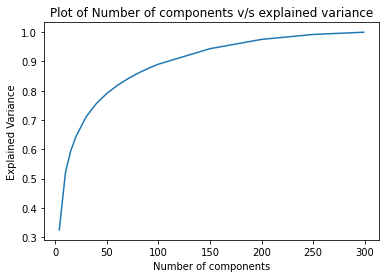

In [30]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,30,40,50,60,70,80,90,95,100,150,200,250,299] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_excerpt_avg_w2v_pos)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [31]:
best_SVD_w2v = TruncatedSVD(n_components=150,n_iter=20)
best_SVD_w2v.fit(X_train_excerpt_avg_w2v_pos)

X_train_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_train_excerpt_avg_w2v_pos)
X_test_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_test_excerpt_avg_w2v_pos)

### Truncated SVD for Avg Word2Vec Concat

Number of components = 4 and explained variance = 0.37891052654748314
Number of components = 10 and explained variance = 0.5582715194620803
Number of components = 15 and explained variance = 0.625026646499425
Number of components = 20 and explained variance = 0.6669918106120533
Number of components = 30 and explained variance = 0.7260690143255701
Number of components = 40 and explained variance = 0.7640503882632618
Number of components = 50 and explained variance = 0.7927170729712761
Number of components = 60 and explained variance = 0.8151601250910059
Number of components = 70 and explained variance = 0.833915587927239
Number of components = 80 and explained variance = 0.849711926302481
Number of components = 90 and explained variance = 0.8635581515574603
Number of components = 95 and explained variance = 0.8700044745204436
Number of components = 100 and explained variance = 0.8758868067660605
Number of components = 150 and explained variance = 0.9203728469508181
Number of components 

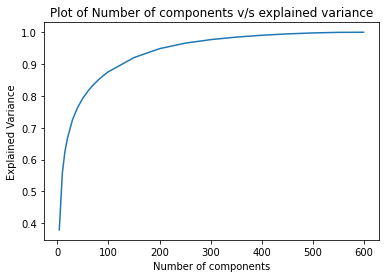

In [32]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,30,40,50,60,70,80,90,95,100,150,200,250,300,350,400,450,500,550,599] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_excerpt_avg_w2v_pos_concat)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [34]:
best_SVD_w2v = TruncatedSVD(n_components=300,n_iter=20)
best_SVD_w2v.fit(X_train_excerpt_avg_w2v_pos_concat)

X_train_excerpt_avgw2v_svd_concat = best_SVD_w2v.transform(X_train_excerpt_avg_w2v_pos_concat)
X_test_excerpt_avgw2v_svd_concat = best_SVD_w2v.transform(X_test_excerpt_avg_w2v_pos_concat)

# Various Models

In [35]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"Avg Word2Vec Pos":(X_train_excerpt_avg_w2v_pos,X_test_excerpt_avg_w2v_pos),"Avg Word2Vec Pos Concat":(X_train_excerpt_avg_w2v_pos_concat,X_test_excerpt_avg_w2v_pos_concat)}

### Function to run all models together

In [36]:
def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1983s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0657s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    4.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.6s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6243968588354021
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6447761206645234


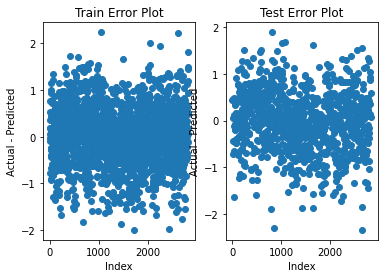

 50%|█████     | 1/2 [00:05<00:05,  5.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    7.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.0s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.6117400807905926
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6447843590258816


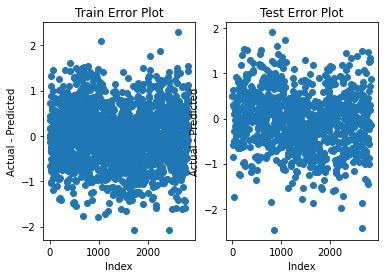

100%|██████████| 2/2 [00:12<00:00,  6.38s/it]


In [37]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0284s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0776s.) Setting batch_size=4.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1534s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.5905399444340607
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6470692337963655


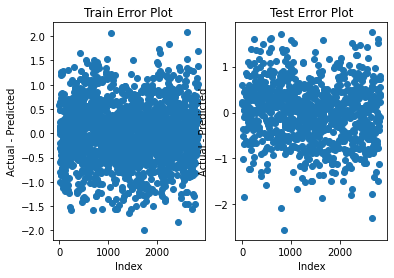

 50%|█████     | 1/2 [00:00<00:00,  1.15it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0794s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1994s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.5500494781278714
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6408199778971728


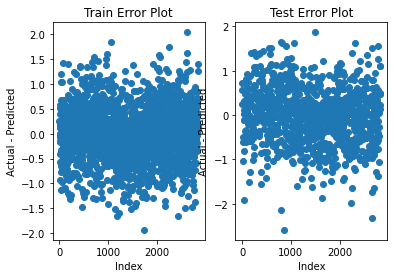

100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


In [38]:
ridge_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1.0]}
ridge = Ridge()

modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1918s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1946s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.7046346972366045
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6934364542024053


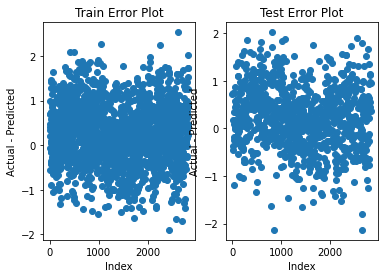

 50%|█████     | 1/2 [00:06<00:06,  6.47s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.6585269660858863
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6801952899422262


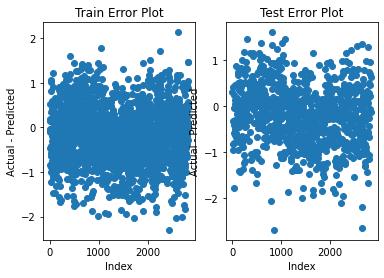

100%|██████████| 2/2 [00:18<00:00,  9.49s/it]


In [39]:
SGD_params = {'alpha':[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   14.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6867483296874378
Root Mean squared Error Test for Avg Word2Vec Pos:  0.7501287104132294


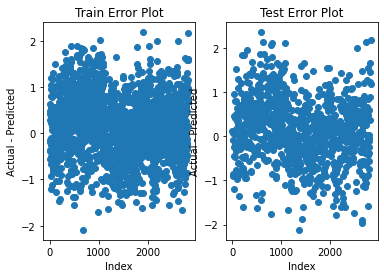

 50%|█████     | 1/2 [00:18<00:18, 18.45s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   29.5s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.7423987801078982
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.7613160188548993


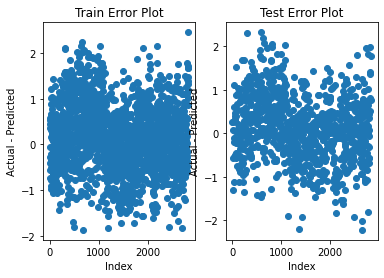

100%|██████████| 2/2 [00:54<00:00, 27.48s/it]


In [40]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0224s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Batch computation too slow (3.9644s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.603563382850956
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6873895518938631


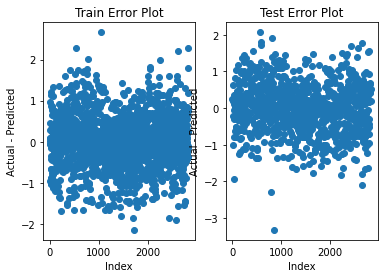

 50%|█████     | 1/2 [02:25<02:25, 145.18s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0336s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Batch computation too slow (5.7045s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.5510486503678288
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.7009312709937323


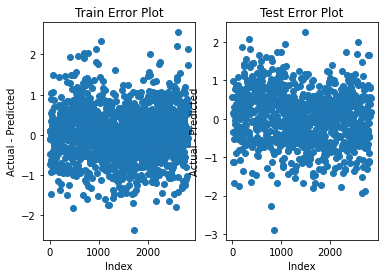

100%|██████████| 2/2 [06:08<00:00, 184.31s/it]


In [41]:
SVR_params = {'C':range(0,30,5)}
LinearSVR = SVR(kernel='linear')

modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.48853590400368674
Root Mean squared Error Test for Avg Word2Vec Pos:  0.645803579616557


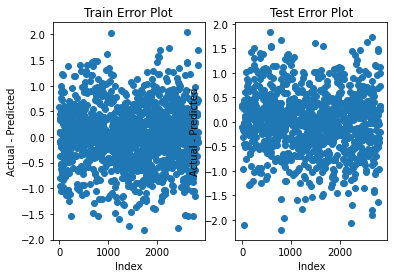

 50%|█████     | 1/2 [01:26<01:26, 86.08s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.509823600376162
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.65313508248764


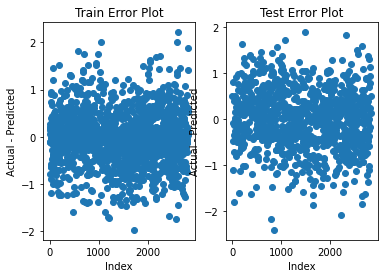

100%|██████████| 2/2 [03:13<00:00, 96.70s/it]


In [42]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
RBF_SVR = SVR(kernel='rbf',gamma="scale")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Poly SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   37.7s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=500, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.5778268297305016
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6461411160607515


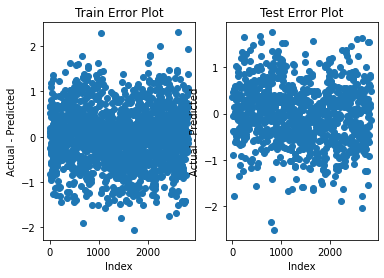

 50%|█████     | 1/2 [00:41<00:41, 42.00s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
SVR(C=600, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.5843926233579388
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6364448861395341


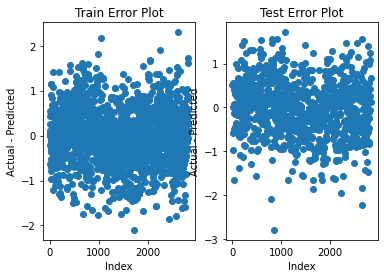

100%|██████████| 2/2 [01:54<00:00, 57.27s/it]


In [43]:
SVR_params = {'C':[500,600,700,900,1000,1500,2000,3000,4000]}
Poly_SVR = SVR(kernel='poly',degree=5,gamma="auto")

modelfunction(Poly_SVR,data,Y_train,Y_test,SVR_params)

### Sigmoid SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   45.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6165032526653678
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6567326677731257


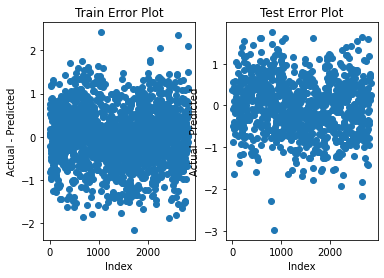

 50%|█████     | 1/2 [00:50<00:50, 50.32s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.5991163398615746
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6416662058310271


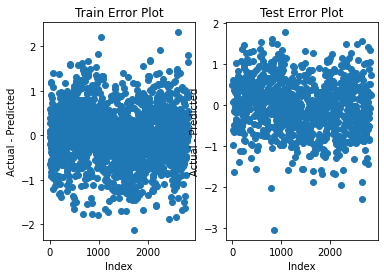

100%|██████████| 2/2 [02:04<00:00, 62.45s/it]


In [44]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
Sig_SVR = SVR(kernel='sigmoid',gamma="auto")

modelfunction(Sig_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.8min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.2653680158640052
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6982640134617231


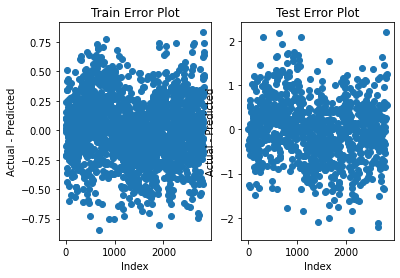

 50%|█████     | 1/2 [06:18<06:18, 378.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 11.5min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.26836612502942464
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6938597600619772


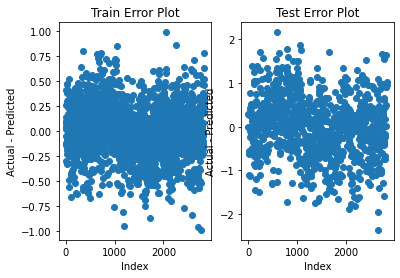

100%|██████████| 2/2 [18:53<00:00, 566.90s/it]


In [45]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
modelfunction(RandomForest,data,Y_train,Y_test,RF_params)

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


[08:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.39254953577027674
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6544945191360102


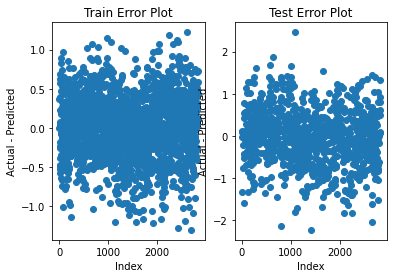

 50%|█████     | 1/2 [02:54<02:54, 174.92s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.6min finished


[08:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.4353453203648919
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6619394543022167


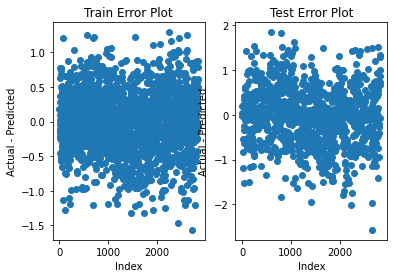

100%|██████████| 2/2 [08:42<00:00, 261.42s/it]


In [46]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
modelfunction(xgb,data,Y_train,Y_test,xgb_params)

### Light GBM

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.1min
[Paralle

----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=180, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.12553432987365054
Root Mean squared Error Test for Avg Word2Vec Pos:  0.651050880084889


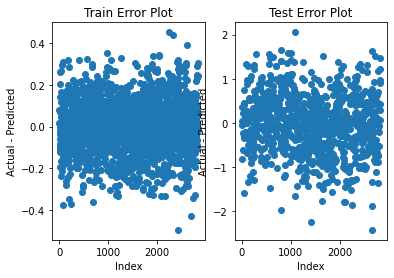

 50%|█████     | 1/2 [15:27<15:27, 927.26s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 28.4min
[Paralle

----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=180, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.10626557198951272
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.649017067512577


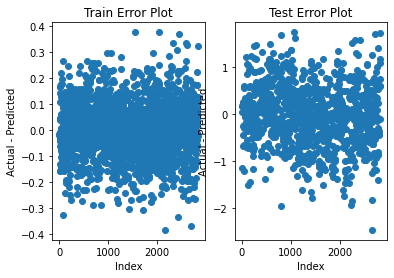

100%|██████████| 2/2 [46:37<00:00, 1398.61s/it]


In [47]:
from lightgbm import LGBMRegressor

LGBM_params = {'boosting_type':['gbdt','dart','goss'],'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

lgbm = LGBMRegressor()
modelfunction(lgbm,data,Y_train,Y_test,LGBM_params)

### CAT Boost

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.1min finished


0:	learn: 1.0017382	total: 147ms	remaining: 26.4s
1:	learn: 0.9718596	total: 228ms	remaining: 20.3s
2:	learn: 0.9458853	total: 313ms	remaining: 18.5s
3:	learn: 0.9206580	total: 400ms	remaining: 17.6s
4:	learn: 0.8946247	total: 483ms	remaining: 16.9s
5:	learn: 0.8728816	total: 568ms	remaining: 16.5s
6:	learn: 0.8541666	total: 655ms	remaining: 16.2s
7:	learn: 0.8357090	total: 746ms	remaining: 16s
8:	learn: 0.8176149	total: 833ms	remaining: 15.8s
9:	learn: 0.8041244	total: 919ms	remaining: 15.6s
10:	learn: 0.7886829	total: 1s	remaining: 15.4s
11:	learn: 0.7766075	total: 1.08s	remaining: 15.2s
12:	learn: 0.7647312	total: 1.17s	remaining: 15.1s
13:	learn: 0.7533723	total: 1.25s	remaining: 14.9s
14:	learn: 0.7435716	total: 1.34s	remaining: 14.7s
15:	learn: 0.7336946	total: 1.42s	remaining: 14.6s
16:	learn: 0.7256240	total: 1.51s	remaining: 14.5s
17:	learn: 0.7155352	total: 1.59s	remaining: 14.3s
18:	learn: 0.7088104	total: 1.67s	remaining: 14.2s
19:	learn: 0.7003070	total: 1.76s	remaining: 1

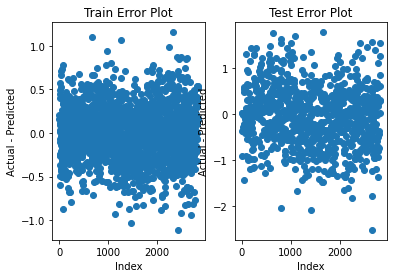

 50%|█████     | 1/2 [10:22<10:22, 622.95s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 19.9min finished


0:	learn: 1.0048966	total: 258ms	remaining: 46.2s
1:	learn: 0.9714564	total: 434ms	remaining: 38.6s
2:	learn: 0.9420568	total: 603ms	remaining: 35.6s
3:	learn: 0.9161810	total: 768ms	remaining: 33.8s
4:	learn: 0.8917191	total: 935ms	remaining: 32.7s
5:	learn: 0.8700588	total: 1.1s	remaining: 32s
6:	learn: 0.8494963	total: 1.27s	remaining: 31.4s
7:	learn: 0.8356682	total: 1.45s	remaining: 31.1s
8:	learn: 0.8180770	total: 1.61s	remaining: 30.6s
9:	learn: 0.8044561	total: 1.77s	remaining: 30.1s
10:	learn: 0.7895027	total: 1.95s	remaining: 29.9s
11:	learn: 0.7772260	total: 2.12s	remaining: 29.6s
12:	learn: 0.7654109	total: 2.29s	remaining: 29.4s
13:	learn: 0.7539308	total: 2.46s	remaining: 29.2s
14:	learn: 0.7427284	total: 2.63s	remaining: 28.9s
15:	learn: 0.7326163	total: 2.79s	remaining: 28.6s
16:	learn: 0.7224882	total: 2.96s	remaining: 28.3s
17:	learn: 0.7148428	total: 3.12s	remaining: 28.1s
18:	learn: 0.7059016	total: 3.28s	remaining: 27.8s
19:	learn: 0.6986563	total: 3.46s	remaining:

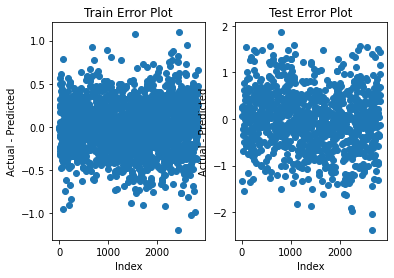

100%|██████████| 2/2 [30:47<00:00, 923.74s/it]


In [48]:
!pip install catboost
from catboost import CatBoostRegressor

CATBoost_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

CB = CatBoostRegressor()
modelfunction(CB,data,Y_train,Y_test,CATBoost_params)

### Histogram Gradient Boosting Regressor

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.1s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.05,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=180, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.12961842395016565
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6509799152927201


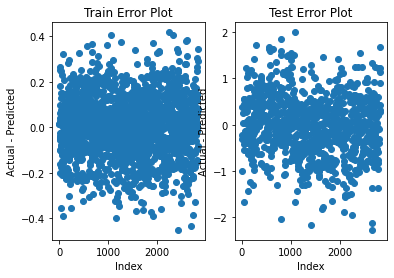

 50%|█████     | 1/2 [06:10<06:10, 370.20s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.5min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos Concat: 
HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.05,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=180, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos Concat:  0.11163990537878568
Root Mean squared Error Test for Avg Word2Vec Pos Concat:  0.6433800051574381


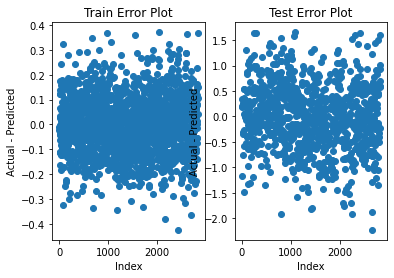

100%|██████████| 2/2 [18:14<00:00, 547.31s/it]


In [49]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

HistBoost_params = {'max_iter': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

HB = HistGradientBoostingRegressor(l2_regularization=1.0)
modelfunction(HB,data,Y_train,Y_test,HistBoost_params)

### Combining all the Predicted Values into a Data Frame

In [50]:
# # Saving the prediction value to a dataframe
# prediction_train = pd.DataFrame(Y_pred_train_Lasso, columns = ['Lasso'])
# prediction_test = pd.DataFrame(Y_pred_test_Lasso, columns = ['Lasso'])

# prediction_train['Ridge'] = Y_pred_train_Ridge
# prediction_test['Ridge'] = Y_pred_test_Ridge
# prediction_train['SGD'] = Y_pred_train_SGD
# prediction_test['SGD'] = Y_pred_test_SGD
# prediction_train['KNN'] = Y_pred_train_KNN
# prediction_test['KNN'] = Y_pred_test_KNN
# prediction_train['LinearSVR'] = Y_pred_train_LinearSVR
# prediction_test['LinearSVR'] = Y_pred_test_LinearSVR
# prediction_train['RBF_SVR'] = Y_pred_train_RBF_SVR
# prediction_test['RBF_SVR'] = Y_pred_test_RBF_SVR
# prediction_train['RandomForest'] = Y_pred_train_RandomForest
# prediction_test['RandomForest'] = Y_pred_test_RandomForest
# prediction_train['XGB'] = Y_pred_train_XGB
# prediction_test['XGB'] = Y_pred_test_XGB


# print(prediction_train.head(5))

### Stacking Regressor

In [51]:
# Regressors
LR = Lasso(alpha=0.0001)
RR = Ridge(alpha=0.01)
SGD = SGDRegressor(alpha=0.000001, penalty='l1')
KNN = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=30)
L_SVR = SVR(C=20,kernel='linear')
R_SVR = SVR(C=300, kernel='rbf')
RF = RandomForestRegressor(n_estimators=70)
XGB_R = XGBRegressor(learning_rate=0.1, n_estimators=180)

# Meta Classifier
SVR_RBF = SVR(kernel='rbf')
XGB_Meta = XGBRegressor()
lr_meta = LinearRegression()

Stack_Regress = StackingRegressor(regressors=[L_SVR,R_SVR,XGB_R,RF],meta_regressor=SVR_RBF)

Stack_Results = Stack_Regress.fit(X_train_excerpt_avg_w2v_pos, Y_train)

Y_pred_train = Stack_Results.predict(X_train_excerpt_avg_w2v_pos)
train_residuals = Y_train - Y_pred_train
Y_pred_test = Stack_Results.predict(X_test_excerpt_avg_w2v_pos)
test_residuals = Y_test - Y_pred_test
mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

print("="*100)
print("Root Mean squared Error Train for Stacking Model", np.sqrt(mse_train))
print("Root Mean squared Error Test for Stacking Model", np.sqrt(mse_test))

[10:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean squared Error Train for Stacking Model 0.17794613407792026
Root Mean squared Error Test for Stacking Model 0.669830895291035
